This notebook demonstrates the method to produce the most basic simulation under consideration using the package `varsim`. The inputs here are:
   - a set of pointings (for simplicity, read in from a csv file)
   - a population of astrophysical sources described by a subclass of `varsim.BasePopulation`. This class must implement the abstract methods of `varsim.BasePopulation`, and provide an index for each source and the model parameters
   - a model for the sources described by a subclass of `varsim.BaseModel`. Again this subclass must implement all of the abstract methods and properties of `varsim.BaseModel`. The essential functionality of this class is to represent an astrophysical source as a model with model parameters, given which, this class has methods of predicting the model flux as a function of time at the top of the earth's atmosphere (ie. no sky noise included).
   - The simulation will be performed using the class `varsim.BasicSimulation` which is a subclass of the abstract base class `varsim.BaseSimulation` and implements concrete methods and properties necessary for the simulation. These methods and properties only use the abstract properties and methods of `BaseModel` and `BasePopulation`, and are therefore guaranteed to with any subclass.

##  Imports

In [1]:
import os

In [2]:
from opsimsummary import HealpixTiles, OpSimOutput

In [3]:
import numpy as np
import pandas as pd

In [4]:
from lsst.sims.photUtils import BandpassDict

In [5]:
from varsim import BasePopulation, BasicSimulation, BaseModel

In [6]:
#hptiles = HealpixTiles(nside=256, 
#                       preComputedMap='/Users/rbiswas/data/LSST/OpSimData/healpixelized_MINION_1016_256_64_indexed.db')

In [7]:
from lsst.sims.catUtils.supernovae import SNObject

In [8]:
import analyzeSN as ans

In [9]:
import varsim

## The quantities of interest

####  Pointings

In [10]:
# The set of pointings randomly kept for convenience.
example_data = varsim.example_data
pointings_File = os.path.join(example_data, 'example_pointings.csv')
pointings = pd.read_csv(pointings_File, index_col='obsHistID')

In [11]:
# To show what this looks like
print(len(pointings))
pointings.head()

14


,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,visitTime,...,moonBright,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec
obsHistID,,,,,,,,,,,,,,,,,,,,,
1,1016,54,316,1.676483,-1.082473,y,2922,59580.033829,0,34.0,...,0.0,105.610378,0.920473,0.0,0.0,1.620307,0.000000,21.021236,1.643930,-1.108924
14,1016,54,1118,1.709686,-0.607725,y,3424,59580.039637,0,34.0,...,0.0,103.104582,0.903960,0.0,0.0,0.055856,4.599568,21.067249,1.691083,-0.634176
13,1016,54,1220,1.664386,-0.566519,y,3386,59580.039190,0,34.0,...,0.0,101.147431,0.903960,0.0,0.0,0.048200,4.776511,21.091149,1.646286,-0.592970
12,1016,54,1212,1.608166,-0.575819,y,3347,59580.038741,0,34.0,...,0.0,98.109397,0.903960,0.0,0.0,0.055665,4.739998,21.128319,1.589958,-0.602270
11,1016,54,1110,1.651280,-0.618574,y,3308,59580.038293,0,34.0,...,0.0,100.125895,0.903960,0.0,0.0,0.056173,4.499824,21.103635,1.632535,-0.645025


In [12]:
# We did not need to have all these columns. The essential columns are ra, dec, filter, 
# fivesigmadepth. It is also good to have fieldID, etc.

### Population of astrophysical sources. 
Here I use supernovae with the SALT model.  I keep two supernovae in a completely random way without attempting to make sense. The important parts are  that no matter how the Population model is implemented, it has:
- `modelparams` : the method which takes the unique index of a supernova in the population and provides its model parameters as a dictionary. An important requirement is that the dictionary as the keys `ra`, `dec`, while the other parameters are completely user dependent
- `idxvalues` : a property which is a sequence of indices. Here the sequence is implemented as a tuple, which is perhaps how it should be for large simulations.

In [13]:
class SALTPopulation(BasePopulation):
    def __init__(self):
        self.x0 = [5.0e-2, 3.e-5]
        self.x1 = [0, .1]
        self.c = [-0.2, 0.5]
        self.t0 = [59581., 59580. ]
        self.z = [0.5, 0.6]
        self.ra = [30., 30.]
        self.dec = [-45., -45.]
        
    def modelparams(self, idx):
        return dict(x0=self.x0[idx], x1=self.x1[idx], c=self.c[idx], t0=self.t0[idx],
                    z=self.z[idx])
    @property
    def idxvalues(self):
        return (x for x in (0, 1))
    @property
    def numSources(self):
        return sum(1 for i in self.idxvalues)
    #@property
    #def hasPositionArray(self):
    #    return False
    #@property
    #def positionArray(self):
    #    return None
    
    #def positions(self, idx):
    #    return dict(ra=self.ra[idx], dec=self.dec[idx])

#### Instantiate the population and demonstrate

In [14]:
sp = SALTPopulation()

In [15]:
# The indices
idxs = tuple(sp.idxvalues)
print(idxs)

(0, 1)


In [16]:
# The model parameters
sp.modelparams(0)

{'c': -0.2, 't0': 59581.0, 'x0': 0.05, 'x1': 0, 'z': 0.5}

and the other one

In [17]:
sp.numSources

2

In [18]:
sp.modelparams(0)

{'c': -0.2, 't0': 59581.0, 'x0': 0.05, 'x1': 0, 'z': 0.5}

### Model of source
- Model : Subclass of `varsim.BaseModel` with its methods implemented. Here I use `lsst.sims.catUtils.supernovae.SNObject` functionality to provide  functions
- Provides `minMjd` and `maxMjd` to restrict the set of pointings over which we will build the light curve.
- `modelFlux`: concrete implementation of abstract method `BaseModel.modelFlux` providing the flux, given the model parameters and `mjd`, `bandpass`.

In [19]:
# We will need the LSST bandpasses. Let us load them using the catsim method
bandpassdict = BandpassDict.loadTotalBandpassesFromFiles()

In [20]:
class Model(SNObject, BaseModel):
    def setModelParameters(self, params):
        paramDict = params.copy()
        # self.setCoords(ra=positions['ra'], dec=positions['dec'])
        self.set(**params)
        self.set_MWebv(0)
        #self.mwEBVfromMaps()
    
    @property
    def minMjd(self):
        return self.mintime()
    @property
    def maxMjd(self):
        return self.maxtime()
    
    def modelFlux(self, mjd, bandpassobj):
        return self.catsimBandFlux(bandpassobject=bandpassobj,
                                      time=mjd)



#### Instantiate the model and demonstrate the functionality

In [21]:
model = Model()

In [22]:
# Let us set parameters (using the method `setModelParameters` in the abstract class
# to the parameters of the first object in SALTParameters)
model.setModelParameters(sp.modelparams(0))    

In [23]:
# Now, this should predict fluxes (in maggies) given a time, and a bandpassobject
f = (model.modelFlux(mjd=59580, bandpassobj=bandpassdict['y']), 
     model.modelFlux(mjd=59580, bandpassobj=bandpassdict['g']))
print(f, -2.5 * np.log10(f))

((2.7530602560557015e-06, 2.7130332558429097e-06), array([ 13.90046071,  13.91636221]))


## Simulation
Now we are ready to do the simulation using the class `BasicSimulation`

In [24]:
bsim = BasicSimulation(sp, model, pointings=pointings, rng=np.random.RandomState(0), 
                       maxObsHistID=1000000, pointingColumnDict=None,
                       pruneWithRadius=False)

In [31]:
bsim.lc(1, maxObsHistID=2e6)

,obsHistID,objid,expMJD,filter,ModelFlux,fieldID,flux,fluxerr,deviations,zp,zpsys
pid,,,,,,,,,,,
1000001,1,1,59580.033829,y,5.195321e-09,316,6.393082e-09,7.814309e-10,1.532779,0.0,ab
14000001,14,1,59580.039637,y,5.195589e-09,1118,6.296351e-09,7.491440e-10,1.469359,0.0,ab
13000001,13,1,59580.039190,y,5.195569e-09,1220,5.309131e-09,7.329094e-10,0.154947,0.0,ab
12000001,12,1,59580.038741,y,5.195548e-09,1212,5.463425e-09,7.083655e-10,0.378163,0.0,ab
11000001,11,1,59580.038293,y,5.195527e-09,1110,4.552264e-09,7.245701e-10,-0.887786,0.0,ab
10000001,10,1,59580.037847,y,5.195507e-09,1021,3.697256e-09,7.563881e-10,-1.980796,0.0,ab
9000001,9,1,59580.037401,y,5.195486e-09,957,4.922714e-09,7.840265e-10,-0.347912,0.0,ab
8000001,8,1,59580.036955,y,5.195466e-09,857,5.317297e-09,7.792265e-10,0.156349,0.0,ab
7000001,7,1,59580.036509,y,5.195445e-09,770,6.149943e-09,7.758312e-10,1.230291,0.0,ab


In [30]:
sp.modelparams(0)

{'c': -0.2, 't0': 59581.0, 'x0': 0.05, 'x1': 0, 'z': 0.5}

In [32]:
!rm *.hdf

In [33]:
bsim.write_simulation(phot_output='sim_phot_all.hdf', pop_output='sim_pop.hdf', method='hdf', key='sim1')

writing 0, False, sim1
writing 1, False, sim1


In [34]:
phot_sim_df = pd.read_hdf('sim_phot_all.hdf', key='sim1')

In [35]:
pop_sim_df = pd.read_hdf('sim_pop.hdf')

In [36]:
phot_sim_df

,obsHistID,objid,expMJD,filter,ModelFlux,fieldID,flux,fluxerr,deviations,zp,zpsys
pid,,,,,,,,,,,
1000000,1,0,59580.033829,y,2.753879e-06,316,2.751058e-06,1.653433e-09,-1.706270,0.0,ab
14000000,14,0,59580.039637,y,2.754019e-06,1118,2.757215e-06,1.638454e-09,1.950775,0.0,ab
13000000,13,0,59580.039190,y,2.754008e-06,1220,2.753177e-06,1.631092e-09,-0.509652,0.0,ab
12000000,12,0,59580.038741,y,2.753997e-06,1212,2.753288e-06,1.620210e-09,-0.438074,0.0,ab
11000000,11,0,59580.038293,y,2.753987e-06,1110,2.751948e-06,1.627357e-09,-1.252795,0.0,ab
10000000,10,0,59580.037847,y,2.753976e-06,1021,2.755252e-06,1.641769e-09,0.777490,0.0,ab
9000000,9,0,59580.037401,y,2.753965e-06,957,2.751295e-06,1.654682e-09,-1.613898,0.0,ab
8000000,8,0,59580.036955,y,2.753954e-06,857,2.753603e-06,1.652410e-09,-0.212740,0.0,ab
7000000,7,0,59580.036509,y,2.753944e-06,770,2.752465e-06,1.650809e-09,-0.895467,0.0,ab


In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [38]:
pop_sim_df

,c,t0,x0,x1,z
0,-0.2,59581.0,0.05000,0.0,0.5
1,0.5,59580.0,0.00003,0.1,0.6


# Scratch

In [35]:
from varsim import BasePopulationFromStochasticModel

In [38]:
class SALTStatPopulation(BasePopulationFromStochasticModel):
    def __init__(self, ):
        self.x0 = [5.0e-2, 3.e-5]
        self.x1 = [0, .1]
        self.c = [-0.2, 0.5]
        self.t0 = [59581., 59580. ]
        self.z = [0.5, 0.6]
        self.ra = [30., 30.]
        self.dec = [-45., -45.]
    
    @property
    def pop_rng(self):
        return 0
    
    @property
    def numSources(self):
        return sum(1 for elem in self.idxvalues)
    #def get_pop_rng(self):
    #    return self.pop_rng
    def set_pop_rng(self, value):
        self._pop_rng = value
        
    def modelparams(self, idx):
            return dict(x0=self.x0[idx], x1=self.x1[idx], c=self.c[idx], t0=self.t0[idx],
                        z=self.z[idx])
        
    @property
    def idxvalues(self):
        return (x for x in (0, 1))
    @property
    def hasPositionArray(self):
        return False
    @property
    def positionArray(self):
        return None
    def positions(self, idx):
        return dict(ra=self.ra[idx], dec=self.dec[idx])
    

In [39]:
snsims = SALTPopulation()

In [40]:
bsim.lc(1).index.values.size

14

In [41]:
np.unique(bsim.lc(0).index.values).size

14

In [42]:
bsim.lc(0).columns

Index([u'obsHistID', u'objid', u'expMJD', u'filter', u'ModelFlux', u'fieldID',
       u'flux', u'fluxerr', u'deviations', u'zp', u'zpsys'],
      dtype='object')

In [43]:
bsim.write_lc(0, 'test_0.hdf', 'hdf')

/usr/local/miniconda/lib/python2.7/site-packages/tables/path.py:100: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)


In [44]:
lc_0 = pd.read_hdf('test_0.hdf')

In [45]:
lc_0

,obsHistID,objid,expMJD,filter,ModelFlux,fieldID,flux,fluxerr,deviations,zp,zpsys
pid,,,,,,,,,,,
1000000,1,0,59580.033829,y,0.000003,316,0.000003,1.640065e-09,0.729091,0.0,ab
14000000,14,0,59580.039637,y,0.000003,1118,0.000003,1.624962e-09,0.128983,0.0,ab
13000000,13,0,59580.039190,y,0.000003,1220,0.000003,1.617539e-09,1.139401,0.0,ab
12000000,12,0,59580.038741,y,0.000003,1212,0.000003,1.606565e-09,-1.234826,0.0,ab
11000000,11,0,59580.038293,y,0.000003,1110,0.000003,1.613773e-09,0.402342,0.0,ab
10000000,10,0,59580.037847,y,0.000003,1021,0.000003,1.628304e-09,-0.684810,0.0,ab
9000000,9,0,59580.037401,y,0.000003,957,0.000003,1.641323e-09,-0.870797,0.0,ab
8000000,8,0,59580.036955,y,0.000003,857,0.000003,1.639033e-09,-0.578850,0.0,ab
7000000,7,0,59580.036509,y,0.000003,770,0.000003,1.637419e-09,-0.311553,0.0,ab


In [46]:
from snsims import PowerLawRates

In [47]:
pr = PowerLawRates(np.random.RandomState(0), numBins=28, fieldArea=1.0)

In [48]:
np.shape(pr.zSamples)

(2480,)

In [ ]:
class SaltPopulation(BasePopulationFromStochasticModel):
    def __init__(self, saltdist, tiling):
        

In [45]:
from astropy.cosmology import Planck15

In [48]:
from opsimsummary import Tiling

In [49]:
dir(Tiling)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 'area',
 'pointingSequenceForTile',
 'positions',
 'samplePatchOnSphere',
 'tileIDSequence',
 'tileIDsForSN']

In [24]:
from opsimsummary import HealpixTiles, Tiling

In [25]:
hpTiles = HealpixTiles(nside=256,
                       preComputedMap='/Users/rbiswas/data/LSST/OpSimData/healpixelized_MINION_1016_256.db')

In [27]:
r = hpTiles.positions(0, 1000)

In [29]:
r[0]

array([ 45.02523028,  45.05311539,  45.02319881,  44.96774065,
        45.03517025,  44.98008981,  44.87830566,  45.06080236,
        45.09397761,  44.96745365,  45.08819774,  44.9046003 ,
        44.98258702,  44.86790104,  44.84317227,  44.90592081,
        45.04757379,  44.85686897,  45.11642737,  44.9606429 ,
        44.89743981,  44.89149724,  45.03616282,  44.93154659,
        45.10538406,  45.11477406,  44.92762674,  45.01087321,
        44.84493695,  44.92006679,  45.03991721,  45.05890568,
        45.01841756,  45.04647184,  44.99506844,  44.96610187,
        45.09272289,  45.13354839,  45.09690722,  45.11932263,
        44.96107212,  44.93496213,  44.9811732 ,  44.94627629,
        45.03381437,  44.83629658,  44.99382664,  45.02697677,
        45.0446629 ,  44.99257132,  44.89301822,  44.98882024,
        45.07208928,  44.91375759,  44.95205567,  45.10182213,
        44.93477769,  44.97925068,  45.04007969,  44.96402705,
        45.01869909,  45.02264202,  44.97772877,  44.97

In [56]:
class TiledPopulation(BasePopulationFromStochasticModel, Tiling):
    def __init__(self):
        return super(self.__class__).__init()

In [57]:
tp = TiledPopulation()

TypeError: Can't instantiate abstract class TiledPopulation with abstract methods area, hasPositions, idxvalues, modelparams, numSources, pointingSequenceForTile, pop_rng, positions, set_pop_rng, tileIDSequence, tileIDsForSN

In [68]:
class HPTP(SALTPopulation):
    def __init__(self):
        return super(self.__class__, self).__init__()

In [64]:
hptp = HPTP()

In [67]:
hptp.area(0)

AttributeError: 'HPTP' object has no attribute 'npix'

In [50]:
from snsims import SALT2_MMDist

In [52]:
mB, x1, c, z = SALT2_MMDist(10000)

(array([   32.,   392.,  1909.,  2785.,  2305.,  1495.,   715.,   259.,
           91.,    17.]),
 array([-0.21080679, -0.16057906, -0.11035133, -0.06012359, -0.00989586,
         0.04033187,  0.09055961,  0.14078734,  0.19101507,  0.24124281,
         0.29147054]),
 <a list of 10 Patch objects>)

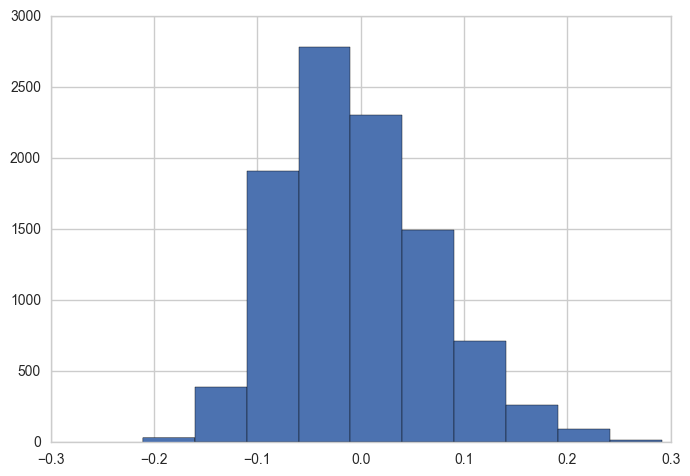

In [56]:
fig, ax = plt.subplots()
ax.hist(c)

In [59]:
from astropy.cosmology import Planck15

In [66]:
pr.DeltaT

10.0

In [64]:
class SALT2Params(BasePopulationFromStochasticModel):
    def __init__(self, zSamples, mjdmin=0., snids=None,
                 Mdisp=0.15, alpha=0.11, beta=-3.14, positions=None,
                 rng=None, cosmo=Planck15):
        self.zSamples = zSamples
        self._snids = snids
        self.alpha = alpha
        self.beta = beta
        self._numSN = len(self.zSamples)
        self._rng = rng
        self.Mdisp = Mdisp
        self.cosmo = cosmo
        self.mjdmin = mjdmin
        self.surveyDuration = self.zSamples.DeltaT * 365.0 
        self._positions = positions
    
    @property
    def mjdmax(self):
        return self.mjdmin + self.surveyDuration
    
    @property
    def numSources(self):
        return self._numSN
   
    @property
    def pop_rng(self):
        return self._rng
    
    def set_pop_rng(self, value):
        self._rng = value
    
    @property
    def idxvalues(self):
        if self._snids is None:
            self._snids = np.arange(self.numSN)
        return self._snids
    
    @property
    def positionArray(self):
        return None
    @property
    def hasPositionArray(self):
        return False
    
    def positions(self, idx):
        return dict(ra=self._positions[0][idx], dec=self._positions[1][idx])
    
    def snparamTable(self):
        if self._paramSamples is not None:
            return self._paramSamples
        timescale = self.mjdmax - self.mjdmin
        T0Vals = self.randomState.uniform(size=self.numSN) * timescale \
            + self.mjdmin
        mB, x1, c, m = SALT2_MMDist(self.numSN)
        x0 = np.zeros(len(mB))
        mB += self.randomState.normal(loc=0., scale=self.Mdisp,
                                      size=self.numSN)
        model = sncosmo.Model(source='SALT2')
        for i, z in enumerate(self.zSamples):
            model.set(z=z, x1=x1[i], c=c[i])
            model.source.set_peakmag(mB[i], 'bessellB', 'ab')
            x0[i] = model.get('x0')
        df = pd.DataFrame(dict(x0=x0, x1=x1, c=c, mB=mB, z=self.zSamples))
        return df
    def modelparams(self, idx):
        return self.snparamTable.ix(idx)
        
        
        
    
        
        
        
    

In [65]:
sp = SALT2Params(pr.zSamples, 59580)

AttributeError: 'numpy.ndarray' object has no attribute 'DeltaT'

In [39]:
bsim.write_simulation('test_sim.hdf', 'hdf', key='test', clobber=False)

TypeError: write_simulation() takes at least 4 arguments (5 given)

In [ ]:
simdf = pd.read_hdf('test_sim.hdf')

In [40]:
simdf

NameError: name 'simdf' is not defined

In [ ]:
bsim.write_population()

In [ ]:
df = pd.read_hdf('test.hdf', key='test')

In [ ]:
bsim.lc(1).to_hdf('test.hdf', key='test', mode='w', append=True, format='t')

In [ ]:
bsim.lc(0).to_hdf('test.hdf', key='test', mode='a', append=True, format='t')

In [ ]:
df = pd.read_hdf('test.hdf', key='test')

In [ ]:
df

In [ ]:
bsim.write_lc(0, 'test_0.csv', 'csv', key=None)

In [ ]:
dfcsv = pd.read_csv('test_0.csv')

In [ ]:
bsim.write_simulation('test.hdf', 'hdf', key=None)

In [ ]:
df = pd.read_hdf('test.hdf', key='0')

In [ ]:
df.to_sql('')

In [ ]:
bsim.write_population('pop.hdf', method='hdf')

In [ ]:
sp.idxvalues

In [ ]:
dfcsv.equals(df, )

In [ ]:
bsim = BasicSimulation(population=sp, model=Model, pointings=)

In [ ]:
bsim.write_lc(0, 'lc_0.hdf', 'hdf')

In [ ]:
pd.DataFrame.to_hdf()

In [ ]:
bsim.write_simulation('test.hdf', 'hdf', key='test')

In [ ]:
simdf = pd.read_hdf('test.hdf', key='test')

In [ ]:
simdf

In [ ]:
sp.positions

In [ ]:
model = Model()

In [ ]:
sp.modelparams(0)

In [ ]:
sp.modelparams(0)

In [ ]:
model.setModelParameters(**sp.modelparams(0))

In [ ]:
model.sn.SNstate

In [ ]:
sn = SNObject()

In [ ]:
params

In [ ]:
sn.setCoords(params['ra'], params['dec'])

In [ ]:
sn.set(**params)

In [ ]:
sn.mwEBVfromMaps()

In [ ]:
sn.SNstate

In [ ]:
model = Model()

In [ ]:
params = sp.modelparams(0).copy()

In [ ]:
for key in ('ra', 'dec'):
    params.pop(key)

In [ ]:
params

In [ ]:
sn.set(**params)

In [ ]:
sn.SNstate

In [ ]:
model.setModelParameters(**sp.modelparams(0))

In [ ]:
model.sn.SNstate

In [ ]:
bandpassobj = bandpassdict['y']

In [ ]:
model.setModelParameters(**sp.modelparams(0))

In [ ]:
model.modelFlux(59580., bandpassobj=bandpassobj)

In [ ]:
bsim = BasicSimulation(sp, model, pointings, rng=np.random.RandomState(0), 
                       maxObsHistID=1000000, pointingColumnDict=None,
                       timeRange=
                      pruneWithRadius=False)

In [ ]:
bsim.model.maxMjd

In [ ]:
bsim.model.r

In [ ]:
scrtch__

In [ ]:
opsout = _OpSimOutput.fromOpSimDB('/Users/rbiswas/data/LSST/OpSimData/minion_1016_sqlite.db',
                                 )

In [ ]:
pointings = opsout.summary.query('expMJD < 59580.04')

In [ ]:
pointings.expMJD.min()

In [ ]:
len(pointings)

In [ ]:
pointings.to_csv('check_poinx``tings.csv')

In [ ]:
!head check_pointings.csv

In [ ]:
from var

In [ ]:
from varsim import BaseExcep

In [ ]:
import pandas as pd

In [ ]:
import numpy as np

In [ ]:
df = pd.DataFrame()

In [ ]:
df['objid'] = np.arange(10)

In [ ]:
df

In [ ]:
280 *2 /4 + 20

In [ ]:
from collections import namedtuple, OrderedDict as odict

In [ ]:
keys = 'abcde'
vals = np.arange(5)
idx = 'pq'
s1 = (dict( (k, v) for (i, k,v) in zip(idx, keys, vals)))
s2 = (dict( (k, v) for (i, k,v) in zip(idx, keys, vals)))



In [ ]:
s = namedtuple(idx, s1)

In [ ]:
s = list()
_ = list(s.append(x) for x in (s1, s2))

In [ ]:
s1

In [ ]:
xx = list()

In [ ]:
xx = tuple(s)

In [ ]:
xx.append(s)

In [ ]:
idx = (l for l in idx)

In [ ]:
df = pd.DataFrame(s, index=idx)

In [ ]:
df

In [ ]:
df = pd.DataFrame()

In [ ]:
type(s)

In [ ]:
df.append(s)